In [1]:
!pip3 install pulp

In [2]:
import pandas as pd
import pulp
import numpy as np
import datetime
import matplotlib.pyplot as plt 

## Q2

In [3]:
df_distance = pd.read_csv("distances.csv")
df_2A = pd.read_csv("part2_ordersA.csv")
df_2B = pd.read_csv("part2_ordersB.csv")

In [4]:
# test orders (please change the dataset below as needed)

# df_2 = df_2A
# start_time = pd.to_datetime('2022-04-02 19:00:00')
# W = 80 # minimum distance occurs at W > 70.5, solutions become infeasible when W < 13
# W_range = range(10, 100, 10)

#################################################################################################################

df_2 = df_2B
start_time = pd.to_datetime('2022-04-02 17:00:00')
W = 82 # minimum distance occurs at W > 81.5, solutions become infeasible when W < 38
W_range = range(30, 100, 5)

In [5]:
df_2

,restaurant,customer,estimated availability
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 5:17 PM
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 5:49 PM
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale),2022-04-02 6:17 PM
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 5:53 PM


### Sets

In [6]:
start = list(df_2["restaurant"].unique()) + list(df_2["customer"].unique())
start.append("Downtown Toronto (Rosedale)")
start = list(dict.fromkeys(start))
start

['Etobicoke (Islington Avenue)',
 'North York (Sweeney Park / Wigmore Park)',
 'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)',
 'Etobicoke (Westmount)',
 'Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)',
 'Downtown Toronto (University of Toronto / Harbord)',
 'Downtown Toronto (Rosedale)',
 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)']

In [7]:
end = list(df_2["restaurant"].unique()) + list(df_2["customer"].unique())
end = list(dict.fromkeys(end))
end

['Etobicoke (Islington Avenue)',
 'North York (Sweeney Park / Wigmore Park)',
 'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)',
 'Etobicoke (Westmount)',
 'Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)',
 'Downtown Toronto (University of Toronto / Harbord)',
 'Downtown Toronto (Rosedale)',
 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)']

In [8]:
step = np.arange(0, len(end)).tolist()
step

[0, 1, 2, 3, 4, 5, 6, 7]

In [9]:
restaurants = df_2["restaurant"].unique().tolist()
restaurants

['Etobicoke (Islington Avenue)',
 'North York (Sweeney Park / Wigmore Park)',
 'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)',
 'Etobicoke (Westmount)']

In [10]:
customers = df_2["customer"].unique().tolist()
customers

['Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)',
 'Downtown Toronto (University of Toronto / Harbord)',
 'Downtown Toronto (Rosedale)',
 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)']

In [11]:
list_order = []
for index, row in df_2.iterrows():
    list_order.append([row["restaurant"], row["customer"]])
print(list_order)

[['Etobicoke (Islington Avenue)', 'Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)'], ['North York (Sweeney Park / Wigmore Park)', 'Downtown Toronto (University of Toronto / Harbord)'], ['Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)', 'Downtown Toronto (Rosedale)'], ['Etobicoke (Westmount)', 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)']]


### Parameters

In [12]:
location_distance = {}
for i in start:
    for j in end: 
        if i == j:
            location_distance[(i,j)] = 0 
        else:
            location_distance[(i,j)] = float(df_distance[(df_distance["origin"] == i)&(df_distance["destination"] == j)]["distance"])

In [13]:
min_arrival_time_mins = {}
for j in end:
    if j in restaurants:
        delta = pd.to_datetime(df_2.loc[df_2["restaurant"] == j]["estimated availability"].tolist()[0]) - start_time
        min_arrival_time_mins[j] = delta/datetime.timedelta(minutes=1)
    if j in customers: 
        #delta = pd.to_datetime(df_2.loc[df_2["customer"] == j]["estimated availability"].tolist()[0]) - start_time
        #min_arrival_time_mins[j] = delta/datetime.timedelta(minutes=1)
        min_arrival_time_mins[j] = 0 
min_arrival_time_mins

{'Etobicoke (Islington Avenue)': 17.0,
 'North York (Sweeney Park / Wigmore Park)': 49.0,
 'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)': 77.0,
 'Etobicoke (Westmount)': 53.0,
 'Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)': 0,
 'Downtown Toronto (University of Toronto / Harbord)': 0,
 'Downtown Toronto (Rosedale)': 0,
 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)': 0}

In [14]:
wait_time = 5
velocity = 3/2 # 40 km/h = 3/2 km/min

travel_time = {}
for i in start:
    for j in end:
        if i == j:
            travel_time[(i,j)] = 0 
        else: 
            if i in customers:
                travel_time[(i,j)] = location_distance[(i,j)]*velocity + wait_time
            else:
                travel_time[(i,j)] = location_distance[(i,j)]*velocity 

### Variables

In [15]:
xvar = pulp.LpVariable.dict("x", (start, end, step), cat=pulp.LpBinary)
dvar = pulp.LpVariable.dict("d", step, lowBound=0.0, cat=pulp.LpContinuous)
wvar = pulp.LpVariable.dict("w", (end, step), lowBound=0.0, cat=pulp.LpContinuous)
zvar = pulp.LpVariable.dict("z", step, lowBound=0.0, cat=pulp.LpContinuous)

### Model & Constraints

In [16]:
flowmodel = pulp.LpProblem(name = "FlowModel", sense = pulp.LpMinimize)

# Constraint: every location visited once
for j in end: 
    flowmodel += pulp.lpSum([xvar[(i,j,t)] for i in start for t in step]) == 1
    
    
# Constraint: Convervation of flow
for t in step[:-1]:
    for j in end:
        flowmodel += (pulp.lpSum([xvar[(i,j,t)] for i in start]) == pulp.lpSum([xvar[(j,k,t+1)] for k in end]))

        
# Constraint: First node (Rosedale) has an outflow of 1 in the first step, others are zero
for i in start:
    if i == "Downtown Toronto (Rosedale)":
        flowmodel += pulp.lpSum([xvar[(i,j,0)] for j in end]) == 1
    else: 
        flowmodel += pulp.lpSum([xvar[(i,j,0)] for j in end]) == 0

        
def find_restaurant_of_customer(customer):
    for order in list_order:
        if customer == order[1]:
            return order[0]
        
# Constraint: make sure driver goes to a restaurant before delivering the food
for t in step: 
    for j in end: 
        if j in customers: 
            flowmodel += pulp.lpSum( [xvar[i,j,t] for i in start]) <= pulp.lpSum([xvar[i, find_restaurant_of_customer(j),t_] for i in start for t_ in step[:t]])
        

# Constraint: Time to arrive at the location of the t-th step
for t in step:
    if t == 0: 
        flowmodel += dvar[t] == pulp.lpSum([ xvar[(i,j,0)] * min_arrival_time_mins[j] for i in start for j in end])
    else:
        flowmodel += dvar[t] >= (dvar[t-1] + pulp.lpSum([ xvar[(i,j,t)] * travel_time[(i,j)] for i in start for j in end]))


        
# Constraint: if arriving at location j, ensures time is at least the min_arrival_time_mins
for t in step:
    for i in start:
        for j in end:
            flowmodel += dvar[t] >= min_arrival_time_mins[j] * xvar[i,j,t]
          
        
# Constraint: define waiting time of each order at step t: wvar[j,t]
for t in step:
    for j in end:
        if j in restaurants:
            flowmodel += wvar[(j,t)]  == 0
        else:
            flowmodel += wvar[(j,t)] == dvar[t] - pulp.lpSum([ min_arrival_time_mins[find_restaurant_of_customer(j)] * xvar[(i,j,t)] for i in start])

            
# # Constraint: ensures the average waiting time of the orders is lower than the maximum W

# implementation idea: 
#         flowmodel += pulp.lpSum([wvar[j,t] * xvar[i,j,t] for i in start]) <= W
# use zvar[t] with big Constant M to denote wvar[j,t] * xvar[i,j,t] as two decision variables cannot be multiplied together
# zvar[t] is the total waiting time up until the step t

M = 500000
for t in step:
    for i in start:
        for j in end:
            if t == 0:
                flowmodel += zvar[t] == 0 
            elif t == 1:
                flowmodel += zvar[t] >= wvar[j,t] - M * (1 - xvar[(i,j,t)])
                flowmodel += zvar[t] <= wvar[j,t] + M * (1 - xvar[(i,j,t)])
            else: 
                flowmodel += zvar[t] >= zvar[t-1] + wvar[(j,t)] - M * (1 - xvar[(i,j,t)])
                flowmodel += zvar[t] <= zvar[t-1] + wvar[(j,t)] + M * (1 - xvar[(i,j,t)])

                
for t in step:
    flowmodel += zvar[t] <= W * len(customers)


#### 1. How much more difficult does the problem become as W decreases or increases? Why?

As W increases, the problem becomes harder as we will be sacrifacing more distances in order to get a feasible solution and meet the maximum average waiting time for each customer. 

#### 3. What is the problem when considering the average waiting time? Propose and test an alternative metric to address the issue you identified, showing how the solution changed with your new measure.
Average waiting time will averge out the extreme cases so that different customers might get very different delivering experiences. Another metric we propose is the waiting time for each customer. 

### Objective Functions

In [17]:
obj = pulp.lpSum([location_distance[(i,j)] * xvar[(i,j,t)] for i in start for j in end for t in step])
flowmodel += obj

### Solution Process

In [18]:
flowmodel.solve()
print("Status:", pulp.LpStatus[flowmodel.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/fa0761f6864846c2bcfeacbed72a2cb1-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/fa0761f6864846c2bcfeacbed72a2cb1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1661 COLUMNS
At line 10845 RHS
At line 12502 BOUNDS
At line 13015 ENDATA
Problem MODEL has 1656 rows, 592 columns and 7711 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.4694 - 0.00 seconds
Cgl0002I 60 variables fixed
Cgl0003I 66 fixed, 3 tightened bounds, 1026 strengthened rows, 0 substitutions
Cgl0003I 46 fixed, 0 tightened bounds, 392 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 576 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 807 strengthened rows, 0 substitutions
Cgl

In [19]:
# Total Distance
totalDistance = pulp.value(flowmodel.objective)
print("Total Distance: " + str(totalDistance))

Total Distance: 51.40200682468172


In [20]:
#### print solution
for t in step: 
    print("Step: " + str(t))
    print("Total travel time (in minutes) up to this step: " + str(dvar[t].varValue))
    
    for i in start: 
        for j in end: 
            
            if xvar[(i,j,t)].varValue > 0.0:
                print("\tLeave from " + str(i))
                print("\tTravel to " + str(j))
                print("\tWaiting time: " + str(wvar[(j,t)].varValue))
                print("\tTotal waiting time up to this step: " + str(zvar[t].varValue))
                
print("Average waiting time: " + str(zvar[t].varValue/len(customers)))


Step: 0
Total travel time (in minutes) up to this step: 77.0
	Leave from Downtown Toronto (Rosedale)
	Travel to Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)
	Waiting time: 0.0
	Total waiting time up to this step: 0.0
Step: 1
Total travel time (in minutes) up to this step: 81.485021
	Leave from Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)
	Travel to North York (Sweeney Park / Wigmore Park)
	Waiting time: 0.0
	Total waiting time up to this step: 0.0
Step: 2
Total travel time (in minutes) up to this step: 92.213805
	Leave from North York (Sweeney Park / Wigmore Park)
	Travel to Downtown Toronto (Rosedale)
	Waiting time: 15.213805
	Total waiting time up to this step: 15.213805
Step: 3
Total travel time (in minutes) up to this step: 116.53413
	Leave from Downtown Toronto (Rosedale)
	Travel to Etobicoke (Westmount)
	Waiting time: 0.0
	Total waiting time up to this step: 15.213805
Step: 4
Total travel time (in minutes) up to this ste

### Loop through W 

In [21]:
def get_distance(W):
    flowmodel = pulp.LpProblem(name = "FlowModel", sense = pulp.LpMinimize)

    # Constraint: every location visited once
    for j in end: 
        flowmodel += pulp.lpSum([xvar[(i,j,t)] for i in start for t in step]) == 1


    # Constraint: Convervation of flow
    for t in step[:-1]:
        for j in end:
            flowmodel += (pulp.lpSum([xvar[(i,j,t)] for i in start]) == pulp.lpSum([xvar[(j,k,t+1)] for k in end]))


    # Constraint: First node (Rosedale) has an outflow of 1 in the first step, others are zero
    for i in start:
        if i == "Downtown Toronto (Rosedale)":
            flowmodel += pulp.lpSum([xvar[(i,j,0)] for j in end]) == 1
        else: 
            flowmodel += pulp.lpSum([xvar[(i,j,0)] for j in end]) == 0


    def find_restaurant_of_customer(customer):
        for order in list_order:
            if customer == order[1]:
                return order[0]

    # Constraint: make sure driver goes to a restaurant before delivering the food
    for t in step: 
        for j in end: 
            if j in customers: 
                flowmodel += pulp.lpSum( [xvar[i,j,t] for i in start]) <= pulp.lpSum([xvar[i, find_restaurant_of_customer(j),t_] for i in start for t_ in step[:t]])


    # Constraint: Time to arrive at the location of the t-th step
    for t in step:
        if t == 0: 
            flowmodel += dvar[t] == pulp.lpSum([ xvar[(i,j,0)] * min_arrival_time_mins[j] for i in start for j in end])
        else:
            flowmodel += dvar[t] >= (dvar[t-1] + pulp.lpSum([ xvar[(i,j,t)] * travel_time[(i,j)] for i in start for j in end]))



    # Constraint: if arriving at location j, ensures time is at least the min_arrival_time_mins
    for t in step:
        for i in start:
            for j in end:
                flowmodel += dvar[t] >= min_arrival_time_mins[j] * xvar[i,j,t]


    # Constraint: define waiting time of each order at step t: wvar[j,t]
    for t in step:
        for j in end:
            if j in restaurants:
                flowmodel += wvar[(j,t)]  == 0
            else:
                flowmodel += wvar[(j,t)] == dvar[t] - pulp.lpSum([ min_arrival_time_mins[find_restaurant_of_customer(j)] * xvar[(i,j,t)] for i in start])


    # # Constraint: ensures the average waiting time of the orders is lower than the maximum W

    # implementation idea: 
    #         flowmodel += pulp.lpSum([wvar[j,t] * xvar[i,j,t] for i in start]) <= W
    # use zvar[t] with big Constant M to denote wvar[j,t] * xvar[i,j,t] as two decision variables cannot be multiplied together
    # zvar[t] is the total waiting time up until the step t

    M = 500000
    for t in step:
        for i in start:
            for j in end:
                if t == 0:
                    flowmodel += zvar[t] == 0 
                elif t == 1:
                    flowmodel += zvar[t] >= wvar[j,t] - M * (1 - xvar[(i,j,t)])
                    flowmodel += zvar[t] <= wvar[j,t] + M * (1 - xvar[(i,j,t)])
                else: 
                    flowmodel += zvar[t] >= zvar[t-1] + wvar[(j,t)] - M * (1 - xvar[(i,j,t)])
                    flowmodel += zvar[t] <= zvar[t-1] + wvar[(j,t)] + M * (1 - xvar[(i,j,t)])


    for t in step:
        flowmodel += zvar[t] <= W * len(customers)

        
    obj = pulp.lpSum([location_distance[(i,j)] * xvar[(i,j,t)] for i in start for j in end for t in step])
    flowmodel += obj 
    
    optimal = flowmodel.solve()
    #print(optimal)

    if optimal == 1:
        return pulp.value(flowmodel.objective)
    else:
        return 0 


In [22]:
distance_list = []

for W in W_range:
    distance_list.append(get_distance(W))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/cd4395e9b3744767b03b58213a91a035-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/cd4395e9b3744767b03b58213a91a035-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1661 COLUMNS
At line 10845 RHS
At line 12502 BOUNDS
At line 13015 ENDATA
Problem MODEL has 1656 rows, 592 columns and 7711 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.4694 - 0.00 seconds
Cgl0002I 60 variables fixed
Cgl0003I 66 fixed, 3 tightened bounds, 1026 strengthened rows, 0 substitutions
Cgl0003I 46 fixed, 0 tightened bounds, 392 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 576 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 807 strengthened rows, 0 substitutions
Cgl

In [23]:
distance_list

[0,
 0,
 65.90619703138421,
 65.00241802135857,
 65.00241802135857,
 56.208047427933266,
 55.62850430505602,
 55.62850430505602,
 51.74082398875608,
 51.74082398875608,
 51.40200682468172,
 51.40200682468172,
 51.40200682468172,
 51.40200682468172]

Text(0.5, 1.0, 'Trade-off Curve')

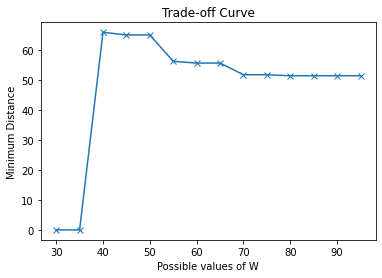

In [24]:
plt.plot(W_range, distance_list, marker='x')
plt.xlabel("Possible values of W")
plt.ylabel("Minimum Distance")
plt.title("Trade-off Curve")